# Introduction to Basics Operation

In [1]:
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pylab as plt

import sys
sys.path.append('code')

%matplotlib inline

Loading some packages.

## Building a Kernel 

### Linear Kenrel (dot product kernel)

We use a simple dot product kernel as a example. The dot product kernel can be defined as
                                $\\ K(X_1,X_2) = X_1*X_2 + \sigma^2\\$
where X1,X2 are the inputs, and $\sigma$ is the only kernel parameter. With 'Kernel' class and a function implement a specified kernel.

In [2]:
from Kernel import Kernel
def dotproduct(X1,X2,params):
    # params[0] is sigma 
    return X1.dot(X2.T) + params[0]

# JIT wapper to speed up
dotproduct = jit(dotproduct)

# Therefore, the kernel can be constructed as
Num_params = 1
dp1 = Kernel(dotproduct,Num_params, jnp.ones(Num_params), [(1e-5, 1e5)] * Num_params, kernel_name='dp')

'[(1e-5, 1e5)] * Num_params' is the bounds. \
Give a example of dataset

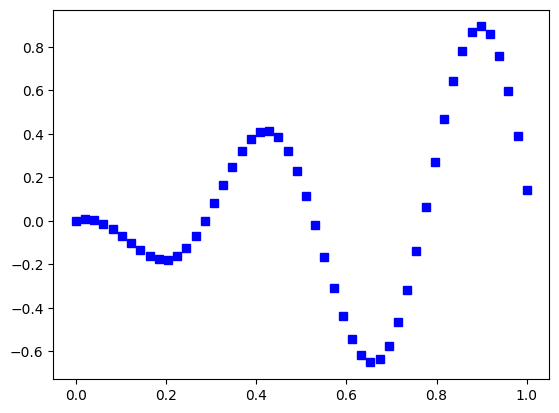

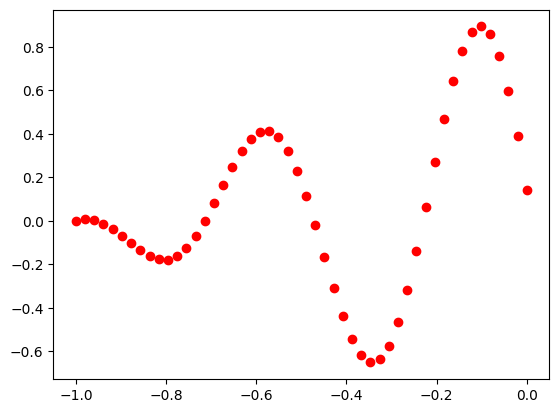

In [3]:
def f(X):
    return jnp.sin(3 * X[:, 0] + 10 * X[:, 1])*X[:, 0]

Num_points = 50
X = jnp.array([jnp.linspace(0, 1, Num_points),jnp.linspace(-1, 0, Num_points)]).T
y = f(X) +jax.random.uniform(jax.random.PRNGKey(0), (Num_points, ))*0.0001 # add some random noisy 


plt.plot(X[:,0],y,"bs")
plt.show()
plt.plot(X[:,1],y,"ro")
plt.show()

We can compute the kernel by

In [4]:
dp1(X,X)

Array([[2.       , 1.9795918, 1.9591837, ..., 1.0408163, 1.0204082,
        1.       ],
       [1.9795918, 1.9600167, 1.9404415, ..., 1.0595585, 1.0399834,
        1.0204082],
       [1.9591837, 1.9404415, 1.9216993, ..., 1.0783007, 1.0595585,
        1.0408163],
       ...,
       [1.0408163, 1.0595585, 1.0783007, ..., 1.9216992, 1.9404414,
        1.9591837],
       [1.0204082, 1.0399834, 1.0595585, ..., 1.9404414, 1.9600167,
        1.9795918],
       [1.       , 1.0204082, 1.0408163, ..., 1.9591837, 1.9795918,
        2.       ]], dtype=float32)

Thanks to JAX, Jacobian of the kernel fucntion with respect to the kernel parameters can be calculated with forward mode. See https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html

In [5]:
#from jax import jacfwd
#dp1_Jaco = jit(jacfwd(dp1,argnums=2))
dp1_Jaco = dp1.gradient
dp1_Jaco(X,X).shape

(50, 50, 1)

The shape of Jacobian should be in shape of (n,n,Num_params).

### RBF Kernel

The de-facto default kernel for Gaussian processes. The kernel computes the similarity between two data points by measuring the distance between them and mapping them into a high-dimensional space. The length scale $\ell$ controls how much two points in the input space need to be separated before the kernel function drops to zero. A large length scale means that the kernel function will be relatively smooth and vary slowly with changes in the input, while a small length scale means that the function will be more wiggly and responsive to small changes in the input.



$k_{\mathrm{RBF}}\left(x, x^{\prime}\right)=\sigma^2 \exp \left(-\frac{\left(x-x^{\prime}\right)^2}{2 \ell^2}\right)$

In [6]:
def rbf_kernel(X1, X2, params):
    params = jnp.array(params)
    if len(params) == 1:
        # isotropic RBF kernel with length scale = params[0]
        sq_norm = jnp.sum((X1[:, jnp.newaxis, :] - X2[jnp.newaxis, :, :]) ** 2, axis=-1)
        return jnp.exp(-0.5 * sq_norm / params[0] ** 2)
    elif len(params) == X1.shape[-1]:
        # ARD (automatic relevance determination) kernel with length scales = params
        sq_diff = (X1[:, jnp.newaxis, :] - X2[jnp.newaxis, :, :]) ** 2
        return jnp.exp(-0.5 * jnp.sum(sq_diff / params ** 2, axis=-1))
    else:
        raise ValueError("Incorrect number of parameters for RBF kernel")
        
# JIT wapper to speed up
rbf = jit(rbf_kernel)

# Therefore, RBF kernel can be constructed as
Num_params = 2
rbf1 = Kernel(rbf,Num_params, jnp.ones(Num_params), [(1e-5, 1e5)] * Num_params, kernel_name='dp')

In [7]:
rbf1(X,X), rbf1.gradient(X,X).shape

(Array([[1.        , 0.9995836 , 0.9983354 , ..., 0.3985058 , 0.383046  ,
         0.36787945],
        [0.9995836 , 1.        , 0.9995836 , ..., 0.4142443 , 0.39850575,
         0.383046  ],
        [0.9983354 , 0.9995836 , 1.        , ..., 0.43024582, 0.41424426,
         0.39850575],
        ...,
        [0.3985058 , 0.4142443 , 0.43024582, ..., 1.        , 0.9995836 ,
         0.9983354 ],
        [0.383046  , 0.39850575, 0.41424426, ..., 0.9995836 , 1.        ,
         0.9995836 ],
        [0.36787945, 0.383046  , 0.39850575, ..., 0.9983354 , 0.9995836 ,
         1.        ]], dtype=float32),
 (50, 50, 2))